In [1]:
%matplotlib inline

import numpy as np
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

In [31]:
nproc = range(1, 17)

In [32]:
def speedup(t_serial, t):
    return t_serial/t

In [38]:
def read_profiling_files(profile_dir_path="."):
    profiling_data = pd.DataFrame()

    json_filenames = [file for file in os.listdir(profile_dir_path) if file.endswith("_profiling.json")]

    for json_filename in json_filenames:
        with open(os.path.join(profile_dir_path, json_filename)) as json_file:
            profiling_data = profiling_data.append(json.load(json_file), ignore_index=True)

    profiling_data.n_processes = profiling_data.n_processes.astype(int)
    profiling_data = profiling_data.sort_values(by=["n_processes"])

    return profiling_data

profiling_data = read_profiling_files("output_dgx-2/2022-04-26T155207/")
print(profiling_data)

         dt n_cuda_devices  n_processes  n_time_steps      nx      ny  \
11  0.00001              1            1         202.0  4096.0  4096.0   
7   0.00001              2            2         202.0  4096.0  4096.0   
14  0.00001              3            3         202.0  4096.0  4096.0   
0   0.00001              4            4         202.0  4096.0  4096.0   
5   0.00001              5            5         202.0  4096.0  4096.0   
8   0.00001              6            6         202.0  4096.0  4096.0   
2   0.00001              7            7         202.0  4096.0  4096.0   
1   0.00001              8            8         202.0  4096.0  4096.0   
15  0.00001              9            9         202.0  4096.0  4096.0   
9   0.00001             10           10         202.0  4096.0  4096.0   
6   0.00001             11           11         202.0  4096.0  4096.0   
12  0.00001             12           12         202.0  4096.0  4096.0   
3   0.00001             13           13         202

## Weak scaling

0.083251953125
11    0.016968
7     0.159668
14    0.139648
0     0.083252
5     0.036621
8     0.090393
2     0.100586
1     0.054260
15    0.061646
9     0.066345
6     0.152771
12    0.051697
3     0.163818
4     0.111450
10    0.072327
13    0.062927
Name: t_step_mpi_halo_exchange_sendreceive, dtype: float64
11    4.906475
7     0.521407
14    0.596154
0     1.000000
5     2.273333
8     0.920999
2     0.827670
1     1.534308
15    1.350495
9     1.254830
6     0.544946
12    1.610390
3     0.508197
4     0.746988
10    1.151055
13    1.322987
Name: t_step_mpi_halo_exchange_sendreceive, dtype: float64


<ipython-input-39-a38b1f547255>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


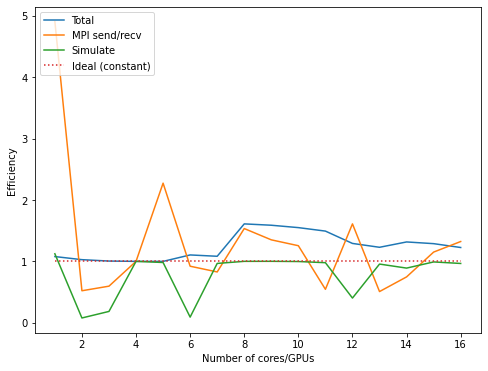

In [39]:
fig, ax = plt.subplots(figsize=(8,6))

# FIXME! Sort AND give new indices
print(profiling_data["t_step_mpi_halo_exchange_sendreceive"][0])
print(profiling_data["t_step_mpi_halo_exchange_sendreceive"])
print(speedup(profiling_data["t_step_mpi_halo_exchange_sendreceive"][0], profiling_data["t_step_mpi_halo_exchange_sendreceive"]))

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_total"][0], profiling_data["t_total"]), label="Total")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi_halo_exchange_sendreceive"][0], profiling_data["t_step_mpi_halo_exchange_sendreceive"]), label="MPI send/recv")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step"][0], profiling_data["t_step"]), label="Simulate")

#ax.plot(nproc, speedup, label="Actual")

ax.plot(nproc, np.ones(len(nproc)), label="Ideal (constant)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Efficiency")
ax.legend(loc="upper left")
fig.show()

## Strong scaling

In [6]:
def amdahls_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [1.0 / (serial_share + parallel_share / float(n)) for n in nproc]

In [7]:
def gustafsons_speedup(parallel_share, nproc):
    serial_share = 1.0 - parallel_share
    return [serial_share + parallel_share * float(n) for n in nproc]

<ipython-input-21-765ec13cd331>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


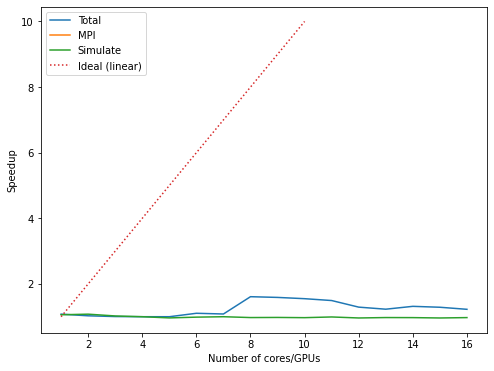

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_total"][0], profiling_data["t_total"]), label="Total")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi_halo_exchange"][0], profiling_data["t_step_mpi_halo_exchange"]), label="MPI")

ax.plot(profiling_data["n_processes"].to_numpy(dtype="int"), 
    speedup(profiling_data["t_step_mpi"][0], profiling_data["t_step_mpi"]), label="Simulate")

#ax.plot(nproc, amdahls_speedup(0.9, nproc), label="Amdahls 90%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.5, nproc), label="Amdahls 50%", linestyle="dashed")
#ax.plot(nproc, amdahls_speedup(0.1, nproc), label="Amdahls 10%", linestyle="dashed")

#ax.plot(nproc, gustafsons_speedup(0.9, nproc), label="Gustafsons 90%")
#ax.plot(nproc, gustafsons_speedup(0.5, nproc), label="Gustafsons 50%")
#ax.plot(nproc, gustafsons_speedup(0.1, nproc), label="Gustafsons 10%")

ax.plot(nproc, nproc, label="Ideal (linear)", linestyle="dotted")

ax.set_xlabel("Number of cores/GPUs")
ax.set_ylabel("Speedup")
ax.legend(loc="upper left")
fig.show()

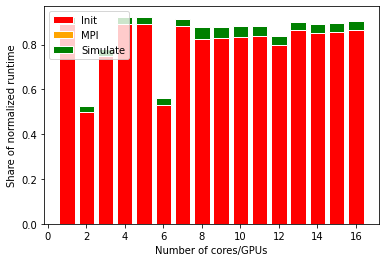

In [18]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])/profiling_data["t_total"]
share_mpi = profiling_data["t_step_mpi_halo_exchange"]/profiling_data["t_total"]
share_simulate = profiling_data["t_step_mpi"]/profiling_data["t_total"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Share of normalized runtime")
plt.legend(loc="upper left")

plt.show()

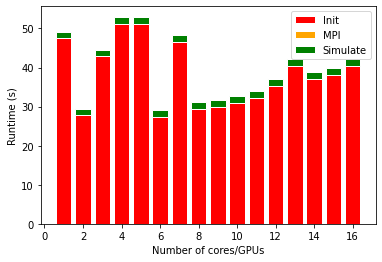

In [19]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step_mpi"]

plt.bar(profiling_data["n_processes"], 
    share_init, color='red', edgecolor='white', width=bar_width, label="Init")

plt.bar(profiling_data["n_processes"], 
    share_mpi, bottom=share_init, color='orange', edgecolor='white', width=bar_width, label="MPI")

plt.bar(profiling_data["n_processes"], 
    share_simulate, bottom=share_init+share_mpi , color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

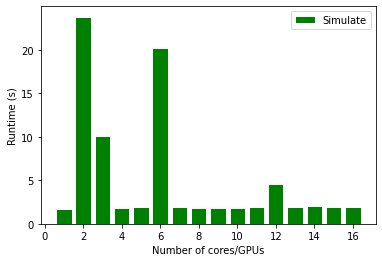

In [22]:
bar_width = 0.8

share_init = (profiling_data["t_init"]+profiling_data["t_sim_init"])
share_mpi = profiling_data["t_step_mpi_halo_exchange"]
share_simulate = profiling_data["t_step"]


plt.bar(profiling_data["n_processes"], 
    share_simulate, color='green', edgecolor='white', width=bar_width, label="Simulate")

plt.xlabel("Number of cores/GPUs")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper right")

plt.show()

1. ~~Sjekk opp behandling av randvilkår. Fungerer ikke som det skal. Offset-problematikk. Få periodiske render til å funke med 1 (først hele domenet, så indre og yttre domene) og 2 subdomener.~~
2. Sjekk overføringer east-west. Kan vi droppe? – Ja, men se punkt 1.
3. ~~Sjekk IC-bug? Bare to felter i K-H?!~~
4. ~~Kjør lenger kjøring~~
5. Sjekk på OsloMet-boks!
6. Sjekk reproduserbarhet av løsning
7. Ny profilering og sjekk av parallelkjøring